### **Load Libraries**

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import tensorflow_hub as hub
import time

# Data augmentation and model preparation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import (AveragePooling2D, Dropout, Flatten, Dense, Input,
                                   Reshape, multiply, add, GlobalAveragePooling2D, Conv2D)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.layers import DepthwiseConv2D, BatchNormalization, Activation, ZeroPadding2D
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, BatchNormalization,
                                     ReLU, GlobalAveragePooling2D, Reshape, Dense, multiply, Add)
from tensorflow.keras.models import Model


#### **Define Paths and Load Data**

In [ ]:
# Define paths
BASE_PATH = "/content/drive/MyDrive/chest_xray"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
TEST_PATH = os.path.join(BASE_PATH, "test")

labels = ['PNEUMONIA', 'NORMAL']
img_size = 224

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                data.append([img_path, label])
            except Exception as e:
                print(e)
    return pd.DataFrame(data, columns=['filepath', 'label'])

# Load data
train = get_data(TRAIN_PATH)
test = get_data(TEST_PATH)

print(train.head(5))
print(f"\nThe shape of The Train data is: {train.shape}")
print(f"The shape of The Test data is: {test.shape}")

                                            filepath      label
0  /content/drive/MyDrive/chest_xray/train/PNEUMO...  PNEUMONIA
1  /content/drive/MyDrive/chest_xray/train/PNEUMO...  PNEUMONIA
2  /content/drive/MyDrive/chest_xray/train/PNEUMO...  PNEUMONIA
3  /content/drive/MyDrive/chest_xray/train/PNEUMO...  PNEUMONIA
4  /content/drive/MyDrive/chest_xray/train/PNEUMO...  PNEUMONIA

The shape of The Train data is: (5233, 2)
The shape of The Test data is: (625, 2)


In [ ]:
# Create datasets with progressive resizing support
IMAGE_SIZE = (224,224)

print('\nTraining Images:')
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,  # Increased validation split for better evaluation
    subset='training',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('\nValidation Images:')
validation_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('\nTesting Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

# Get class names
train_labels = train_ds.class_names
test_labels = test_ds.class_names
validation_labels = validation_ds.class_names

class_labels = ['NORMAL', 'PNEUMONIA']
label_encoder = LabelEncoder()
label_encoder.fit(class_labels)

# Normalize pixel values
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))



Training Images:
Found 5232 files belonging to 2 classes.
Using 4186 files for training.

Validation Images:
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.

Testing Images:
Found 624 files belonging to 2 classes.


In [ ]:
# Enhanced class weights calculation with focal loss approach
allTrainFiles = [os.path.join(TRAIN_PATH, "NORMAL", f) for f in os.listdir(os.path.join(TRAIN_PATH, "NORMAL"))] + \
                [os.path.join(TRAIN_PATH, "PNEUMONIA", f) for f in os.listdir(os.path.join(TRAIN_PATH, "PNEUMONIA"))]

trainLabels = [0 if "NORMAL" in p else 1 for p in allTrainFiles]
trainLabels = to_categorical(trainLabels)
classTotals = trainLabels.sum(axis=0)
classWeight = {i: classTotals.max() / classTotals[i] for i in range(len(classTotals))}

# Enhanced data generators with medical-specific augmentations
BATCH_SIZE = 16
INIT_LR = 1e-4
EPOCHS = 30

trainAug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode="nearest")

valAug = ImageDataGenerator(preprocessing_function=preprocess_input)

trainGen = trainAug.flow_from_directory(
    TRAIN_PATH,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=True,
    batch_size=BATCH_SIZE)

validationGen = valAug.flow_from_directory(
    TRAIN_PATH,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)

testGen = valAug.flow_from_directory(
    TEST_PATH,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)


Found 5232 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#### **Build model**

In [ ]:
# Count files
def retrieveNumberOfFiles(path):
    return len([f for f in os.listdir(os.path.join(path, "NORMAL")) if f.endswith('.jpeg')] +
               [f for f in os.listdir(os.path.join(path, "PNEUMONIA")) if f.endswith('.jpeg')])

totalTrain = retrieveNumberOfFiles(TRAIN_PATH)
totalTest = retrieveNumberOfFiles(TEST_PATH)


# Enhanced Squeeze and Excitation block with improved architecture
def squeeze_excite_block(input_tensor, ratio=16):
    init = input_tensor
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal',
               use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(se)
    se = Dropout(0.2)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = multiply([init, se])
    return x

# Enhanced EfficientNetB3-based model with improved SE integration
def enhanced_efficientnet_model(input_shape=(224, 224, 3), include_top=True, weights='imagenet', classes=2, ratio=16):
    base_model = EfficientNetB3(input_shape=input_shape, include_top=False, weights=weights)

    x = base_model.output

    # Add SE block after base model
    x = squeeze_excite_block(x, ratio=ratio)

    if include_top:
        x = GlobalAveragePooling2D()(x)
        x = BatchNormalization()(x)  # Added batch normalization
        x = Dropout(0.3)(x)
        x = Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)
        x = Dense(classes, activation='softmax', use_bias=True)(x)

    model = Model(inputs=base_model.input, outputs=x)

    # Unfreeze top layers for fine-tuning
    for layer in base_model.layers[:-20]:  # Freeze bottom layers
        layer.trainable = False

    for layer in base_model.layers[-20:]:  # Unfreeze top 20 layers
        layer.trainable = True

    return model

#### **Compile Model**

In [ ]:
# Model architecture with enhanced backbone
CLASSES = ["normal","pneumonia"]
model = enhanced_efficientnet_model(input_shape=(224, 224, 3), include_top=True,
                                   weights='imagenet', classes=len(CLASSES), ratio=16)

# Custom focal loss for imbalanced data
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        alpha_t = y_true * alpha + (tf.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (tf.ones_like(y_true) - y_true) * (tf.ones_like(y_true) - y_pred)
        focal_loss = - alpha_t * tf.pow((tf.ones_like(y_true) - p_t), gamma) * tf.math.log(p_t)

        return tf.reduce_mean(focal_loss)
    return focal_loss_fixed

# Compile model with enhanced optimizer and loss
print("Compiling model")
opt = AdamW(learning_rate=INIT_LR, weight_decay=1e-4)  # Using AdamW for better regularization
model.compile(loss=focal_loss(alpha=0.25, gamma=2.0), optimizer=opt,
              metrics=["accuracy", "precision", "recall"])

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Compiling model


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 11,479,601 (43.79 MB)

 Trainable params: 4,065,634 (15.51 MB)

 Non-trainable params: 7,413,967 (28.28 MB)

#### **Model Training**

In [ ]:
# Enhanced callbacks for better training control
os.makedirs("/content/drive/MyDrive/chest_xray", exist_ok=True)
MCName = os.path.sep.join(["/content/drive/MyDrive/chest_xray",
                          "enhanced_efficientnet_weights-{epoch:03d}-{val_loss:.4f}.keras"])

checkpoint = ModelCheckpoint(
    MCName,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1,
    save_weights_only=False
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Stop if no improvement for 3 epochs
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce LR by half
    patience=4,  # Reduce LR if no improvement for 4 epochs
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]

# Train model with enhanced configuration
print("Model Fitting")
start_time = time.time()

history = model.fit(
    x=trainGen,
    steps_per_epoch=totalTrain // BATCH_SIZE,
    validation_data=validationGen,
    validation_steps=totalTrain // (5 * BATCH_SIZE),  # More validation steps
    class_weight=classWeight,
    callbacks=callbacks,
    epochs=EPOCHS)

training_time = (time.time() - start_time) / 60
print(f"\nTraining completed in {training_time:.2f} minutes")

Model Fitting
Epoch 1/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7519 - loss: 0.3428 - precision: 0.7519 - recall: 0.7519

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.10933, saving model to /content/drive/MyDrive/chest_xray/enhanced_efficientnet_weights-001-0.1093.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 2320s 7s/step - accuracy: 0.7520 - loss: 0.3426 - precision: 0.7520 - recall: 0.7520 - val_accuracy: 0.8452 - val_loss: 0.1093 - val_precision: 0.8452 - val_recall: 0.8452 - learning_rate: 1.0000e-04
Epoch 2/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8543 - loss: 0.2141 - precision: 0.8543 - recall: 0.8543
Epoch 2: val_loss improved from 0.10933 to 0.08097, saving model to /content/drive/MyDrive/chest_xray/enhanced_efficientnet_weights-002-0.0810.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 1586s 5s/step - accuracy: 0.8544 - loss: 0.2141 - precision: 0.8544 - recall: 0.8544 - val_accuracy: 0.9519 - val_loss: 0.0810 - val_precision: 0.9519 - val_recall: 0.9519 - learning_rate: 1.0000e-04
Epoch 3/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8875 - loss: 0.1908 - precision: 0.8875 - recall: 0.8875
Epo

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9399 - loss: 0.1086 - precision: 0.9399 - recall: 0.9399
Epoch 10: val_loss improved from 0.06750 to 0.06709, saving model to /content/drive/MyDrive/chest_xray/enhanced_efficientnet_weights-010-0.0671.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 1591s 5s/step - accuracy: 0.9399 - loss: 0.1086 - precision: 0.9399 - recall: 0.9399 - val_accuracy: 0.9740 - val_loss: 0.0671 - val_precision: 0.9740 - val_recall: 0.9740 - learning_rate: 1.0000e-04
Epoch 11/30
228/327 ━━━━━━━━━━━━━━━━━━━━ 6:44 4s/step - accuracy: 0.9400 - loss: 0.1009 - precision: 0.9400 - recall: 0.9400

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9391 - loss: 0.1024 - precision: 0.9391 - recall: 0.9391
Epoch 11: val_loss improved from 0.06709 to 0.06672, saving model to /content/drive/MyDrive/chest_xray/enhanced_efficientnet_weights-011-0.0667.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 1570s 5s/step - accuracy: 0.9391 - loss: 0.1024 - precision: 0.9391 - recall: 0.9391 - val_accuracy: 0.9827 - val_loss: 0.0667 - val_precision: 0.9827 - val_recall: 0.9827 - learning_rate: 1.0000e-04
Epoch 12/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9439 - loss: 0.0966 - precision: 0.9439 - recall: 0.9439
Epoch 12: val_loss improved from 0.06672 to 0.06551, saving model to /content/drive/MyDrive/chest_xray/enhanced_efficientnet_weights-012-0.0655.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 1587s 5s/step - accuracy: 0.9439 - loss: 0.0966 - precision: 0.9439 - recall: 0.9439 - val_accuracy: 0.9769 - val_loss: 0.0655 - val_precision: 0.9769 - val_recall: 0.9769 - learning_rate: 1.0000e-04
Epoch 13

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9408 - loss: 0.1006 - precision: 0.9408 - recall: 0.9408
Epoch 13: val_loss did not improve from 0.06551
327/327 ━━━━━━━━━━━━━━━━━━━━ 1580s 5s/step - accuracy: 0.9408 - loss: 0.1006 - precision: 0.9408 - recall: 0.9408 - val_accuracy: 0.9673 - val_loss: 0.0679 - val_precision: 0.9673 - val_recall: 0.9673 - learning_rate: 1.0000e-04
Epoch 14/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9402 - loss: 0.0980 - precision: 0.9402 - recall: 0.9402
Epoch 14: val_loss improved from 0.06551 to 0.06471, saving model to /content/drive/MyDrive/chest_xray/enhanced_efficientnet_weights-014-0.0647.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 1480s 5s/step - accuracy: 0.9402 - loss: 0.0980 - precision: 0.9402 - recall: 0.9402 - val_accuracy: 0.9808 - val_loss: 0.0647 - val_precision: 0.9808 - val_recall: 0.9808 - learning_rate: 1.0000e-04
Epoch 15/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9447 - loss: 0.0925 - precision: 0.9447 - re

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9499 - loss: 0.0878 - precision: 0.9499 - recall: 0.9499
Epoch 16: val_loss improved from 0.06449 to 0.06357, saving model to /content/drive/MyDrive/chest_xray/enhanced_efficientnet_weights-016-0.0636.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 1586s 5s/step - accuracy: 0.9499 - loss: 0.0878 - precision: 0.9499 - recall: 0.9499 - val_accuracy: 0.9817 - val_loss: 0.0636 - val_precision: 0.9817 - val_recall: 0.9817 - learning_rate: 1.0000e-04
Epoch 17/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9510 - loss: 0.0836 - precision: 0.9510 - recall: 0.9510
Epoch 17: val_loss improved from 0.06357 to 0.05973, saving model to /content/drive/MyDrive/chest_xray/enhanced_efficientnet_weights-017-0.0597.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 1594s 5s/step - accuracy: 0.9510 - loss: 0.0836 - precision: 0.9510 - recall: 0.9510 - val_accuracy: 0.9875 - val_loss: 0.0597 - val_precision: 0.9875 - val_recall: 0.9875 - learning_rate: 1.0000e-04
Epoch 18

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9398 - loss: 0.0939 - precision: 0.9398 - recall: 0.9398
Epoch 18: val_loss improved from 0.05973 to 0.05784, saving model to /content/drive/MyDrive/chest_xray/enhanced_efficientnet_weights-018-0.0578.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 1534s 5s/step - accuracy: 0.9398 - loss: 0.0939 - precision: 0.9398 - recall: 0.9398 - val_accuracy: 0.9933 - val_loss: 0.0578 - val_precision: 0.9933 - val_recall: 0.9933 - learning_rate: 1.0000e-04
Epoch 19/30
293/327 ━━━━━━━━━━━━━━━━━━━━ 2:14 4s/step - accuracy: 0.9525 - loss: 0.0814 - precision: 0.9525 - recall: 0.9525

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9524 - loss: 0.0815 - precision: 0.9524 - recall: 0.9524
Epoch 19: val_loss improved from 0.05784 to 0.05715, saving model to /content/drive/MyDrive/chest_xray/enhanced_efficientnet_weights-019-0.0571.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 1578s 5s/step - accuracy: 0.9524 - loss: 0.0815 - precision: 0.9524 - recall: 0.9524 - val_accuracy: 0.9923 - val_loss: 0.0571 - val_precision: 0.9923 - val_recall: 0.9923 - learning_rate: 1.0000e-04
Epoch 20/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9582 - loss: 0.0782 - precision: 0.9582 - recall: 0.9582
Epoch 20: val_loss improved from 0.05715 to 0.05680, saving model to /content/drive/MyDrive/chest_xray/enhanced_efficientnet_weights-020-0.0568.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 1522s 5s/step - accuracy: 0.9582 - loss: 0.0782 - precision: 0.9582 - recall: 0.9582 - val_accuracy: 0.9942 - val_loss: 0.0568 - val_precision: 0.9942 - val_recall: 0.9942 - learning_rate: 1.0000e-04
Epoch 21

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9641 - loss: 0.0757 - precision: 0.9641 - recall: 0.9641
Epoch 21: val_loss improved from 0.05680 to 0.05316, saving model to /content/drive/MyDrive/chest_xray/enhanced_efficientnet_weights-021-0.0532.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 1583s 5s/step - accuracy: 0.9641 - loss: 0.0757 - precision: 0.9641 - recall: 0.9641 - val_accuracy: 0.9981 - val_loss: 0.0532 - val_precision: 0.9981 - val_recall: 0.9981 - learning_rate: 1.0000e-04
Epoch 22/30
115/327 ━━━━━━━━━━━━━━━━━━━━ 13:40 4s/step - accuracy: 0.9375 - loss: 0.0855 - precision: 0.9375 - recall: 0.9375

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


259/327 ━━━━━━━━━━━━━━━━━━━━ 4:24 4s/step - accuracy: 0.9448 - loss: 0.0817 - precision: 0.9448 - recall: 0.9448

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9468 - loss: 0.0807 - precision: 0.9468 - recall: 0.9468
Epoch 22: val_loss did not improve from 0.05316
327/327 ━━━━━━━━━━━━━━━━━━━━ 1571s 5s/step - accuracy: 0.9468 - loss: 0.0807 - precision: 0.9468 - recall: 0.9468 - val_accuracy: 0.9904 - val_loss: 0.0550 - val_precision: 0.9904 - val_recall: 0.9904 - learning_rate: 1.0000e-04
Epoch 23/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9568 - loss: 0.0779 - precision: 0.9568 - recall: 0.9568
Epoch 23: val_loss did not improve from 0.05316
327/327 ━━━━━━━━━━━━━━━━━━━━ 1445s 4s/step - accuracy: 0.9568 - loss: 0.0779 - precision: 0.9568 - recall: 0.9568 - val_accuracy: 0.9798 - val_loss: 0.0583 - val_precision: 0.9798 - val_recall: 0.9798 - learning_rate: 1.0000e-04
Epoch 24/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9508 - loss: 0.0767 - precision: 0.9508 - recall: 0.9508
Epoch 24: val_loss did not improve from 0.05316
327/327 ━━━━━━━━━━━━━━━━━━━━ 1522s 5s/ste

### **Evaluation**


Evaluating model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 233s 6s/step - accuracy: 0.8956 - loss: 0.0823 - precision: 0.8956 - recall: 0.8956
Test Accuracy: 92.47%
Test Loss: 0.0748
39/39 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.93      0.86      0.90       234
   PNEUMONIA       0.92      0.96      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.91      0.92       624
weighted avg       0.93      0.92      0.92       624


Confusion Matrix:
[[201  33]
 [ 14 376]]
Accuracy: 0.9247
Sensitivity: 0.9641
Specificity: 0.8590


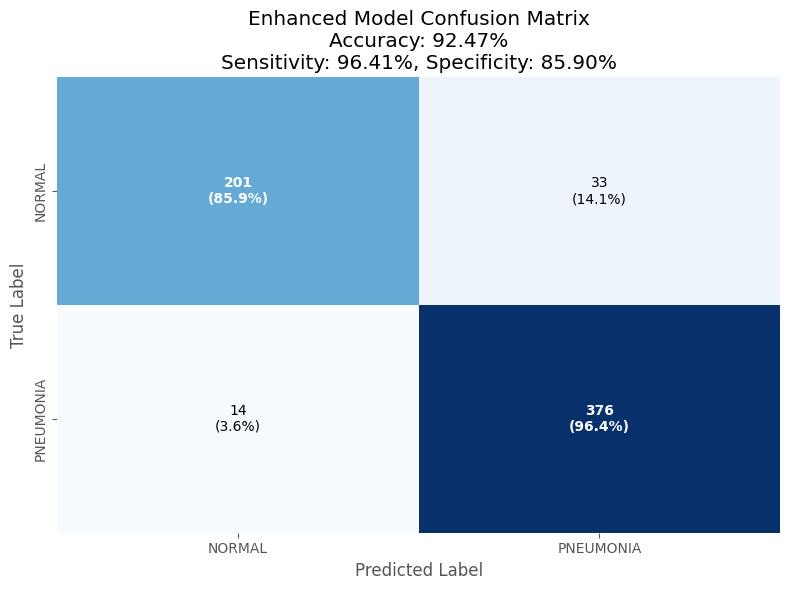

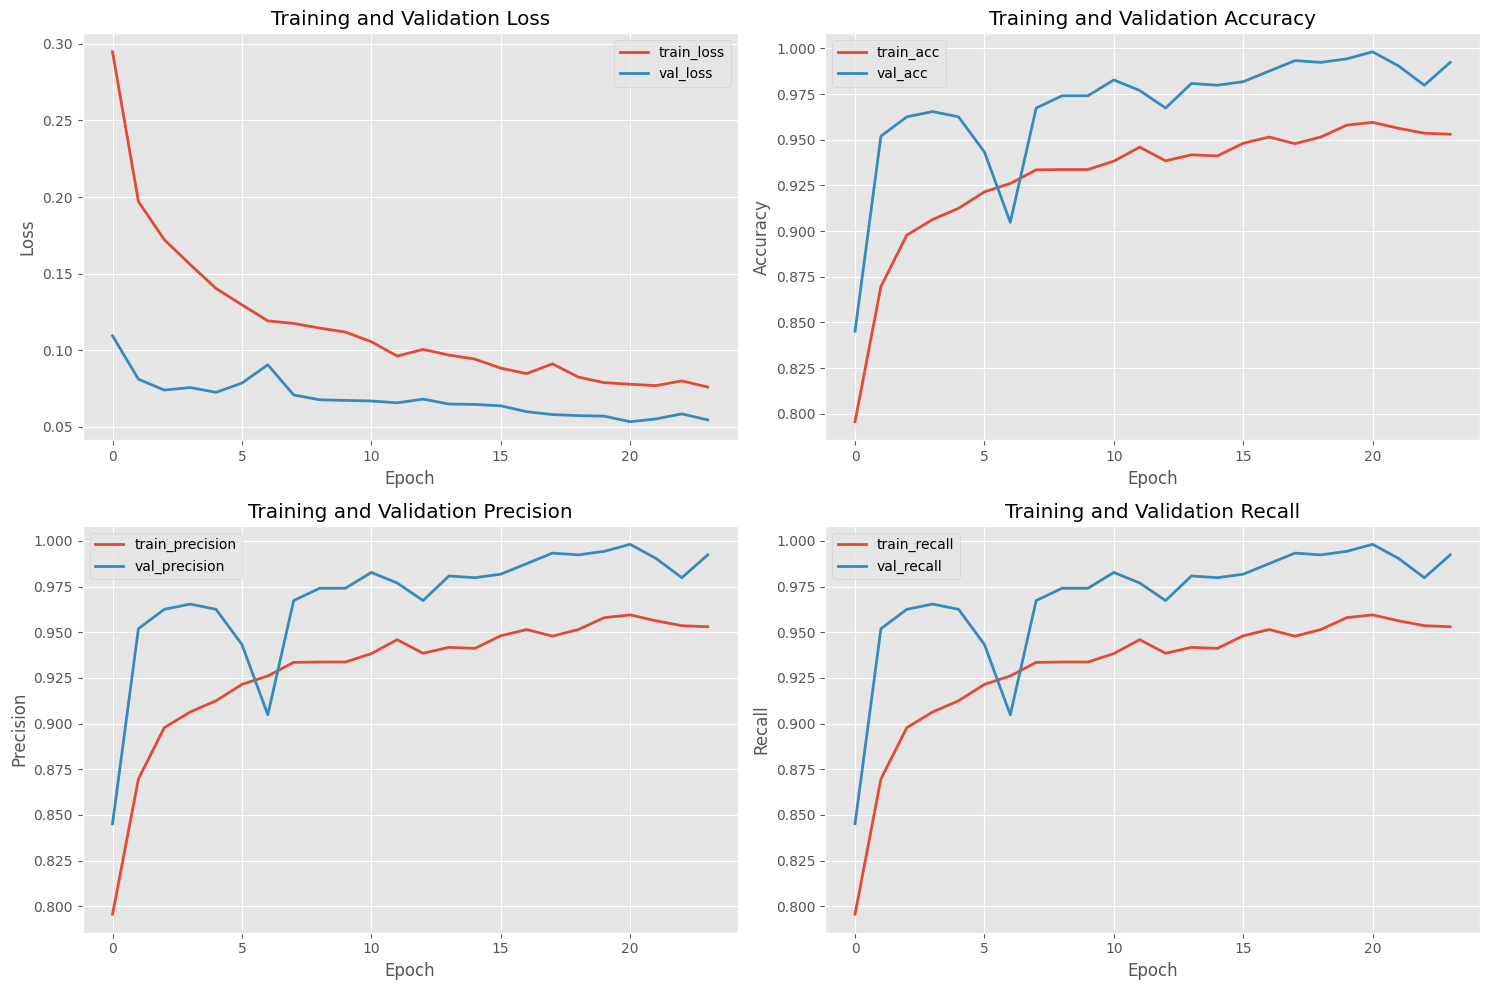

In [ ]:
# Evaluate model
print("\nEvaluating model...")
test_results = model.evaluate(testGen, batch_size=BATCH_SIZE)
print("Test Accuracy: {:.2f}%".format(test_results[1] * 100))
print("Test Loss: {:.4f}".format(test_results[0]))

# Predictions and classification report
predIdxs = model.predict(testGen)
predTest = np.argmax(predIdxs, axis=1)

print("\nClassification Report:")
print(classification_report(testGen.classes, predTest, target_names=testGen.class_indices.keys()))

# Confusion matrix
cm = confusion_matrix(testGen.classes, predTest)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
# Calculate Sensitivity and Specificity
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print("\nConfusion Matrix:")
print(cm)
print("Accuracy: {:.4f}".format(acc))
print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

# Plot confusion matrix with class-wise percentages
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=testGen.class_indices.keys(),
                yticklabels=testGen.class_indices.keys(),
                cbar=False)

# Add annotations with counts and class-wise percentages
for i in range(cm.shape[0]):
    row_sum = cm[i, :].sum()
    for j in range(cm.shape[1]):
        percentage = (cm[i, j] / row_sum) * 100 if row_sum > 0 else 0
        is_correct = (i == j)
        text = f"{cm[i, j]}\n({percentage:.1f}%)"
        ax.text(j + 0.5, i + 0.5, text,
               ha='center', va='center',
               color='white' if is_correct else 'black',
               weight='bold' if is_correct else 'normal')

plt.title(f"Enhanced Model Confusion Matrix\nAccuracy: {acc:.2%}\nSensitivity: {sensitivity:.2%}, Specificity: {specificity:.2%}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Plot training history with enhanced metrics
plt.style.use("ggplot")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Loss plot
ax1.plot(history.history["loss"], label="train_loss", linewidth=2)
ax1.plot(history.history["val_loss"], label="val_loss", linewidth=2)
ax1.set_title("Training and Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(history.history["accuracy"], label="train_acc", linewidth=2)
ax2.plot(history.history["val_accuracy"], label="val_acc", linewidth=2)
ax2.set_title("Training and Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)

# Precision plot
if 'precision' in history.history:
    ax3.plot(history.history["precision"], label="train_precision", linewidth=2)
    ax3.plot(history.history["val_precision"], label="val_precision", linewidth=2)
    ax3.set_title("Training and Validation Precision")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Precision")
    ax3.legend()
    ax3.grid(True)

# Recall plot
if 'recall' in history.history:
    ax4.plot(history.history["recall"], label="train_recall", linewidth=2)
    ax4.plot(history.history["val_recall"], label="val_recall", linewidth=2)
    ax4.set_title("Training and Validation Recall")
    ax4.set_xlabel("Epoch")
    ax4.set_ylabel("Recall")
    ax4.legend()
    ax4.grid(True)

plt.tight_layout()
plt.show()

### **Evaluate from best saved model**

Loading the best model from: /content/drive/MyDrive/chest_xray/enhanced_efficientnet_weights-021-0.0532.keras

Evaluating the best model...
39/39 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8956 - loss: 0.0823 - precision: 0.8956 - recall: 0.8956
Test Accuracy (Best Model): 92.47%
Test Loss (Best Model): 0.0748
39/39 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step

Classification Report (Best Model):
              precision    recall  f1-score   support

      NORMAL     0.9349    0.8590    0.8953       234
   PNEUMONIA     0.9193    0.9641    0.9412       390

    accuracy                         0.9247       624
   macro avg     0.9271    0.9115    0.9182       624
weighted avg     0.9252    0.9247    0.9240       624


Confusion Matrix (Best Model):
[[201  33]
 [ 14 376]]
Accuracy (Best Model): 0.9247
Sensitivity (Best Model): 0.9641
Specificity (Best Model): 0.8590


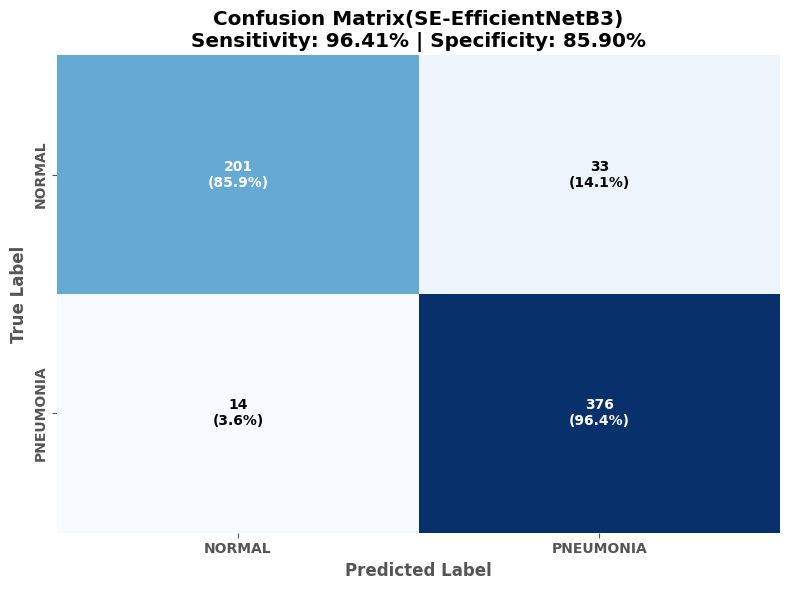

In [ ]:
import os
import glob
import re
from tensorflow.keras.models import load_model

# Find the best model checkpoint based on validation loss
list_of_files = glob.glob('/content/drive/MyDrive/chest_xray/enhanced_efficientnet_weights-*.keras')
if not list_of_files:
    print("No model checkpoints found.")
else:
    # Extract validation loss from filenames and find the best model
    best_loss = float('inf')
    best_model_path = None
    for file_path in list_of_files:
        match = re.search(r'-(\d+\.\d+)\.keras$', file_path)
        if match:
            loss = float(match.group(1))
            if loss < best_loss:
                best_loss = loss
                best_model_path = file_path

    if best_model_path:
        print(f"Loading the best model from: {best_model_path}")

        # Load the best model
        best_model = load_model(best_model_path, custom_objects={'focal_loss_fixed': focal_loss(alpha=0.25, gamma=2.0)})

        # Evaluate the best model
        print("\nEvaluating the best model...")
        test_results_best = best_model.evaluate(testGen, batch_size=BATCH_SIZE)
        print("Test Accuracy (Best Model): {:.2f}%".format(test_results_best[1] * 100))
        print("Test Loss (Best Model): {:.4f}".format(test_results_best[0]))

        # Predictions and classification report for the best model
        predIdxs_best = best_model.predict(testGen)
        predTest_best = np.argmax(predIdxs_best, axis=1)

        print("\nClassification Report (Best Model):")
        print(classification_report(testGen.classes, predTest_best, target_names=testGen.class_indices.keys(), digits=4))

        # Confusion matrix for the best model
        cm_best = confusion_matrix(testGen.classes, predTest_best)
        total_best = sum(sum(cm_best))
        acc_best = (cm_best[0, 0] + cm_best[1, 1]) / total_best
        sensitivity_best = cm_best[1, 1] / (cm_best[1, 0] + cm_best[1, 1]) # Fixed: should be cm_best
        specificity_best = cm_best[0, 0] / (cm_best[0, 0] + cm_best[0, 1])

        print("\nConfusion Matrix (Best Model):")
        print(cm_best)
        print("Accuracy (Best Model): {:.4f}".format(acc_best))
        print("Sensitivity (Best Model): {:.4f}".format(sensitivity_best))
        print("Specificity (Best Model): {:.4f}".format(specificity_best))

        # Plot confusion matrix for the best model
        plt.figure(figsize=(8, 6))
        ax_best = sns.heatmap(cm_best, annot=False, fmt='d', cmap='Blues',
                              xticklabels=testGen.class_indices.keys(),
                              yticklabels=testGen.class_indices.keys(),
                              cbar=False)

        # Make tick labels bold
        ax_best.set_xticklabels(ax_best.get_xticklabels(), fontweight='bold')
        ax_best.set_yticklabels(ax_best.get_yticklabels(), fontweight='bold')

        # Add annotations with counts and class-wise percentages for the best model, in bold
        for i in range(cm_best.shape[0]):
            row_sum_best = cm_best[i, :].sum()
            for j in range(cm_best.shape[1]):
                percentage_best = (cm_best[i, j] / row_sum_best) * 100 if row_sum_best > 0 else 0
                text_best = f"{cm_best[i, j]}\n({percentage_best:.1f}%)"
                ax_best.text(j + 0.5, i + 0.5, text_best,
                             ha='center', va='center',
                             color='white' if i == j else 'black',
                             fontweight='bold')  # Always bold

        plt.title(f"Confusion Matrix(SE-EfficientNetB3)\nSensitivity: {sensitivity_best:.2%} | Specificity: {specificity_best:.2%}",  fontweight='bold')
        plt.xlabel("Predicted Label", fontweight='bold')
        plt.ylabel("True Label", fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print("Could not find a suitable model checkpoint.")

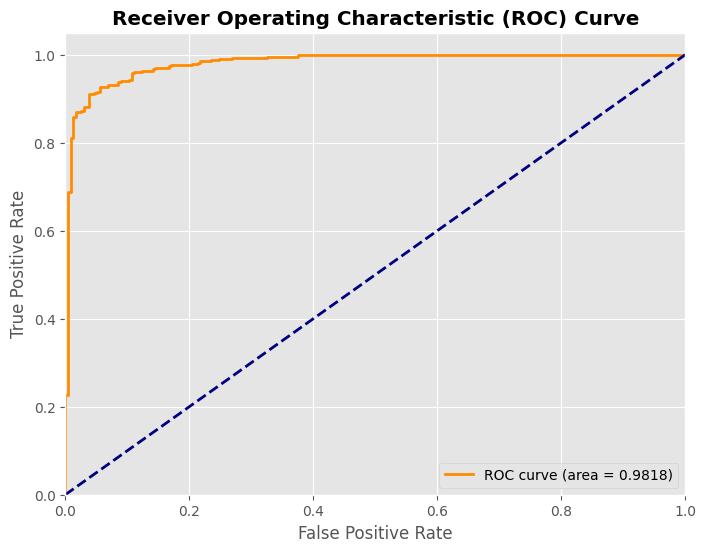


AUROC Score: 0.9818


In [ ]:
from sklearn.metrics import roc_curve, auc

# Calculate and plot ROC curve and AUROC
y_true = testGen.classes
y_pred_prob = predIdxs_best[:, 1] # Probability of the positive class (PNEUMONIA)

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"\nAUROC Score: {roc_auc:.4f}")

#### **Model Size**

In [ ]:
import os
import glob
import re

# Find the best model checkpoint based on validation loss from the previous code
list_of_files = glob.glob('/content/drive/MyDrive/chest_xray/enhanced_efficientnet_weights-*.keras')
if not list_of_files:
    print("No model checkpoints found.")
else:
    best_loss = float('inf')
    best_model_path = None
    for file_path in list_of_files:
        match = re.search(r'-(\d+\.\d+)\.keras$', file_path)
        if match:
            loss = float(match.group(1))
            if loss < best_loss:
                best_loss = loss
                best_model_path = file_path

    if best_model_path:
        # Get the size of the best model file
        file_size_bytes = os.path.getsize(best_model_path)

        # Convert bytes to megabytes for better readability
        file_size_megabytes = file_size_bytes / (1024 * 1024)

        print(f"The size of the best saved model ({os.path.basename(best_model_path)}) is: {file_size_megabytes:.2f} MB")
    else:
        print("Could not find a suitable model checkpoint.")

The size of the best saved model (enhanced_efficientnet_weights-021-0.0532.keras) is: 76.14 MB


### **Model Architectural Design**

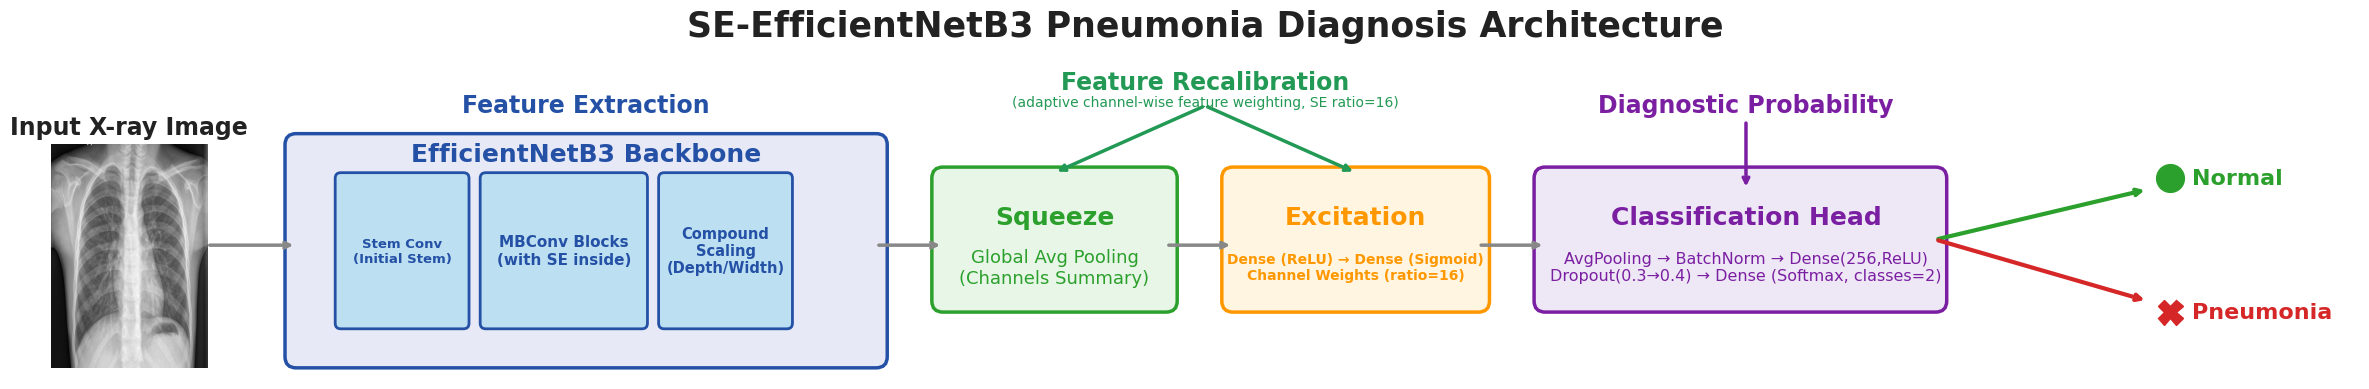

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import numpy as np
import os

# Use the provided X-ray image path
img_path = "/content/drive/MyDrive/chest_xray/test/NORMAL/NORMAL-1110860-0001.jpeg"
img = mpimg.imread(img_path)

fig, ax = plt.subplots(figsize=(24, 6))
ax.axis('off')

# -- Section Headings --
ax.text(2.6, 3.35, "Feature Extraction", ha='center', va='bottom', fontsize=17, fontweight='bold', color='#2451a6')
ax.text(8.15, 3.55, "Feature Recalibration", ha='center', va='bottom', fontsize=17, fontweight='bold', color='#229954')
ax.text(8.15, 3.42, "(adaptive channel-wise feature weighting, SE ratio=16)", ha='center', va='bottom', fontsize=10, color='#229954')
ax.text(13.0, 3.35, "Diagnostic Probability", ha='center', va='bottom', fontsize=17, fontweight='bold', color='#7b1fa2')

# -- Two-pointed arrow from Feature Recalibration to Squeeze and Excitation blocks --
ax.annotate('', xy=(6.8, 2.85), xytext=(8.15, 3.45),
            arrowprops=dict(arrowstyle='->', lw=2.5, color='#229954'))
ax.annotate('', xy=(9.5, 2.85), xytext=(8.15, 3.45),
            arrowprops=dict(arrowstyle='->', lw=2.5, color='#229954'))

# -- Single arrow from "Diagnostic Probability Head" to Classification Head block --
ax.annotate('', xy=(13.0, 2.7), xytext=(13.0, 3.32),
            arrowprops=dict(arrowstyle='->', lw=2.5, color='#7b1fa2'))

# -- Show Input X-ray Image --
ax.imshow(img, extent=[-2.2, -0.8, 1.1, 3.1], zorder=2, cmap='gray')
ax.text(-1.5, 3.15, "Input X-ray Image", ha='center', va='bottom', fontsize=17, fontweight='bold', color='#222')

# -- EfficientNetB3 Block (bigger, with bigger sub-blocks) --
eff_box = patches.FancyBboxPatch((0, 1.2), 5.2, 1.9, boxstyle="round,pad=0.1", edgecolor='#2451a6', facecolor='#e7eaf6', lw=2.5, zorder=2)
ax.add_patch(eff_box)
ax.text(2.6, 3.02, "EfficientNetB3 Backbone", ha='center', va='center', fontsize=18, fontweight='bold', color='#2451a6')

# Sub-blocks inside EfficientNetB3 (bigger, spaced)
ax.add_patch(patches.FancyBboxPatch((0.4, 1.5), 1.1, 1.3, boxstyle="round,pad=0.05", edgecolor='#2451a6', facecolor='#bcdff1', lw=2, zorder=3))
ax.text(0.95, 2.15, "Stem Conv\n(Initial Stem)", ha='center', va='center', fontsize=9.5, color='#2451a6', fontweight='bold')

ax.add_patch(patches.FancyBboxPatch((1.7, 1.5), 1.4, 1.3, boxstyle="round,pad=0.05", edgecolor='#2451a6', facecolor='#bcdff1', lw=2, zorder=3))
ax.text(2.4, 2.15, "MBConv Blocks\n(with SE inside)", ha='center', va='center', fontsize=11, color='#2451a6', fontweight='bold')

ax.add_patch(patches.FancyBboxPatch((3.3, 1.5), 1.1, 1.3, boxstyle="round,pad=0.05", edgecolor='#2451a6', facecolor='#bcdff1', lw=2, zorder=3))
ax.text(3.85, 2.15, "Compound\nScaling\n(Depth/Width)", ha='center', va='center', fontsize=10.5, color='#2451a6', fontweight='bold')

# -- Squeeze Block --
sq_box = patches.FancyBboxPatch((5.8, 1.7), 2.0, 1.1, boxstyle="round,pad=0.1", edgecolor='#2ca02c', facecolor='#e7f6e7', lw=2.5, zorder=2)
ax.add_patch(sq_box)
ax.text(6.8, 2.45, "Squeeze", ha='center', va='center', fontsize=18, fontweight='bold', color='#2ca02c')
ax.text(6.8, 2.0, "Global Avg Pooling\n(Channels Summary)", ha='center', va='center', fontsize=13, color='#2ca02c')

# -- Excitation Block --
ex_box = patches.FancyBboxPatch((8.4, 1.7), 2.2, 1.1, boxstyle="round,pad=0.1", edgecolor='#ff9800', facecolor='#fff5e1', lw=2.5, zorder=2)
ax.add_patch(ex_box)
ax.text(9.5, 2.45, "Excitation", ha='center', va='center', fontsize=18, fontweight='bold', color='#ff9800')
ax.text(9.5, 2.0, "Dense (ReLU) → Dense (Sigmoid)\nChannel Weights (ratio=16)", ha='center', va='center', fontsize=10, color='#ff9800', fontweight='bold')

# -- Classification Head Block (includes Output Layer) --
clf_box = patches.FancyBboxPatch((11.2, 1.7), 3.5, 1.1, boxstyle="round,pad=0.1", edgecolor='#7b1fa2', facecolor='#ede7f6', lw=2.5, zorder=2)
ax.add_patch(clf_box)
ax.text(13.0, 2.45, "Classification Head", ha='center', va='center', fontsize=18, fontweight='bold', color='#7b1fa2')
ax.text(13.0, 2.0, "AvgPooling → BatchNorm → Dense(256,ReLU)\nDropout(0.3→0.4) → Dense (Softmax, classes=2)", ha='center', va='center', fontsize=11.5, color='#7b1fa2')

# -- Output icons and labels (well separated to the right) --
normal_x, normal_y = 16.8, 2.8
pneumonia_x, pneumonia_y = 16.8, 1.6

ax.plot([normal_x], [normal_y], marker="o", color='#2ca02c', markersize=20, lw=0, zorder=4)
ax.text(normal_x + 0.2, normal_y, "Normal", va='center', ha='left', fontsize=16, color='#2ca02c', fontweight='bold')
ax.plot([pneumonia_x], [pneumonia_y], marker="X", color='#d62728', markersize=18, lw=0, zorder=4)
ax.text(pneumonia_x + 0.2, pneumonia_y, "Pneumonia", va='center', ha='left', fontsize=16, color='#d62728', fontweight='bold')

# -- Arrows for flow --
arrowprops = dict(facecolor='#888', edgecolor='#888', arrowstyle='->', lw=2.5)
ax.annotate('', xy=(0, 2.2), xytext=(-0.8, 2.2), arrowprops=arrowprops)
ax.annotate('', xy=(5.8, 2.2), xytext=(5.2, 2.2), arrowprops=arrowprops)
ax.annotate('', xy=(8.4, 2.2), xytext=(7.8, 2.2), arrowprops=arrowprops)
ax.annotate('', xy=(11.2, 2.2), xytext=(10.6, 2.2), arrowprops=arrowprops)

# -- Output arrows (from classification head to output icons, at angles) --
clf_right_x = 14.7
clf_center_y = 2.25
ax.annotate('', xy=(normal_x-0.2, normal_y-0.1), xytext=(clf_right_x, clf_center_y),
            arrowprops=dict(facecolor='#2ca02c', edgecolor='#2ca02c', arrowstyle='->', lw=3))
ax.annotate('', xy=(pneumonia_x-0.2, pneumonia_y+0.1), xytext=(clf_right_x, clf_center_y),
            arrowprops=dict(facecolor='#d62728', edgecolor='#d62728', arrowstyle='->', lw=3))

plt.title("SE-EfficientNetB3 Pneumonia Diagnosis Architecture", fontsize=25, fontweight='bold', color='#222', pad=22)
plt.xlim(-2.2, 18.5)
plt.ylim(1, 3.8)
plt.tight_layout()
plt.show()

### **Deployment Metrics**

In [ ]:
import os
import time
import numpy as np
import psutil
import threading
import gc
from tensorflow.keras.models import load_model
import glob
import re
import tensorflow as tf
import tensorflow.keras.backend as K

# Define the focal loss function
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_factor = tf.ones_like(y_true) * alpha
        alpha_t = tf.where(tf.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        cross_entropy = -K.log(p_t)
        weight = alpha_t * K.pow((1 - p_t), gamma)
        loss = weight * cross_entropy
        return K.mean(K.sum(loss, axis=1))
    return focal_loss_fixed


# 1. Identify and Load SE-EfficientNetB3 Model

# Find the checkpoint file with lowest validation loss
checkpoint_files = glob.glob("/content/drive/MyDrive/chest_xray/enhanced_efficientnet_weights-*.keras")
best_file = None
best_loss = float('inf')
for file in checkpoint_files:
    m = re.search(r'enhanced_efficientnet_weights-\d+-([0-9]+\.[0-9]+)\.keras', file)
    if m:
        loss = float(m.group(1))
        if loss < best_loss:
            best_loss = loss
            best_file = file

if not best_file:
    raise FileNotFoundError("No SE-EfficientNetB3 checkpoint found.")
model = load_model(best_file, custom_objects={'focal_loss_fixed': focal_loss(alpha=0.25, gamma=2.0)})
model_size_mb = os.path.getsize(best_file) / (1024 ** 2)
print(f"Loaded SE-EfficientNetB3 from: {best_file}")
print(f"Model size: {model_size_mb:.2f} MB")


# 2. System Hardware Specifications (unchanged)

cpu_freq = psutil.cpu_freq().current
cpu_cores_phys = psutil.cpu_count(logical=False)
cpu_cores_log = psutil.cpu_count(logical=True)
total_ram_gb = psutil.virtual_memory().total / (1024 ** 3)
print(f"CPU: {cpu_freq:.0f} MHz, {cpu_cores_phys}p/{cpu_cores_log}l cores")
print(f"Total RAM: {total_ram_gb:.2f} GB")


# 3. Memory Utilization Analysis (unchanged)

process = psutil.Process(os.getpid())
ram_after_load_mb = process.memory_info().rss / (1024 ** 2)
print(f"RAM after load (RSS): {ram_after_load_mb:.1f} MB")

# Prepare test image
testGen.reset()
test_images, _ = next(testGen)
sample_image = test_images[0:1]

# Stabilize memory
_ = model.predict(sample_image, verbose=0)
gc.collect()

# Capture memory during inference
ram_before = process.memory_info().rss
_ = model.predict(sample_image, verbose=0)
ram_after = process.memory_info().rss

ram_peak_mb = max(ram_before, ram_after) / (1024 ** 2)
ram_used_mb = ram_peak_mb - ram_after_load_mb
print(f"Peak RAM during inference: {ram_peak_mb:.1f} MB")
print(f"RAM used by inference: {ram_used_mb:.1f} MB")


# 4. Inference Time Performance (unchanged)

testGen.reset()
test_images, _ = next(testGen)
num_images = 50
test_samples = test_images[:num_images]

# Warm-up
_ = model.predict(test_samples[0:1], verbose=0)

# Measure latency
times_ms = []
start = time.perf_counter()
_ = model.predict(test_samples, verbose=0)
end = time.perf_counter()
time_per_image_ms = (end - start) * 1000 / num_images
times_ms.append(time_per_image_ms)

mean_inf_ms = np.mean(times_ms)
std_inf_ms = np.std(times_ms) if len(times_ms) > 1 else 0
print(f"Inference time ({num_images} images): {mean_inf_ms:.2f} ± {std_inf_ms:.2f} ms (per image)")


# 5. CPU Utilization and Power Estimation (unchanged)

cpu_samples = []
stop_sampling = False

def monitor_cpu(interval=0.05):
    while not stop_sampling:
        cpu_samples.append(psutil.cpu_percent(interval=interval))

monitor_thread = threading.Thread(target=monitor_cpu)
monitor_thread.daemon = True
monitor_thread.start()

test_img = test_samples[0:1]
start_wall = time.perf_counter()
_ = model.predict(test_img, verbose=0)
end_wall = time.perf_counter()

stop_sampling = True
monitor_thread.join(timeout=1.0)

avg_cpu = np.mean(cpu_samples) if cpu_samples else 0
est_power_w = (avg_cpu / 100) * 5  # Raspberry Pi power model
print(f"CPU utilization: {avg_cpu:.1f}%")
print(f"Estimated power: {est_power_w:.2f} W (Pi equivalent)")


# 6. Results Summary for SE-EfficientNetB3
# ======================================================================
print("\n" + "="*50)
print(f"{' SE-EFFICIENTNETB3 DEPLOYMENT METRICS ':.^50}")
print("="*50)
print(f"Model size: {model_size_mb:.2f} MB")
print(f"Inference time ({num_images} images): {mean_inf_ms:.2f} ± {std_inf_ms:.2f} ms")
print(f"Estimated power: {est_power_w:.2f} W")
print("Clinical viability: " +
      ("Yes" if mean_inf_ms <= 1000 and model_size_mb <= 50 else "No"))
print("="*50)

Loaded SE-EfficientNetB3 from: /content/drive/MyDrive/chest_xray/enhanced_efficientnet_weights-021-0.0532.keras
Model size: 76.14 MB
CPU: 2200 MHz, 1p/2l cores
Total RAM: 12.67 GB
RAM after load (RSS): 1004.0 MB
Peak RAM during inference: 1114.0 MB
RAM used by inference: 110.0 MB
Inference time (50 images): 205.83 ± 0.00 ms (per image)
CPU utilization: 48.1%
Estimated power: 2.40 W (Pi equivalent)

...... SE-EFFICIENTNETB3 DEPLOYMENT METRICS ......
Model size: 76.14 MB
Inference time (50 images): 205.83 ± 0.00 ms
Estimated power: 2.40 W
Clinical viability: No
